## Preparing the Data

### 1) Importing the libraries

In [1]:
!pip install underthesea

     |████████████████████████████████| 7.6 MB 5.5 MB/s 
     |████████████████████████████████| 235 kB 32.4 MB/s 
     |████████████████████████████████| 581 kB 42.1 MB/s 
     |████████████████████████████████| 743 kB 42.2 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
import underthesea

### 2) Reading the data

In [3]:
!wget http://www.manythings.org/anki/vie-eng.zip -O vie-eng.zip
!unzip vie-eng.zip

--2022-01-13 03:03:49--  http://www.manythings.org/anki/vie-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.186.54, 104.21.92.44, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.186.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317038 (310K) [application/zip]
Saving to: ‘vie-eng.zip’

vie-eng.zip         100%[===================>] 309.61K  --.-KB/s    in 0.06s   

2022-01-13 03:03:49 (5.01 MB/s) - ‘vie-eng.zip’ saved [317038/317038]

Archive:  vie-eng.zip
  inflating: _about.txt              
  inflating: vie.txt                 


In [4]:
lines = pd.read_table('vie.txt', names=['eng', 'vie'])
lines.reset_index(inplace=True)
lines.rename( columns={ 'index' : 'eng' , 'eng' : 'vie' , 'vie' : 'c' }, inplace=True)
lines.drop('c', axis=1, inplace=True)
lines.vie = lines.vie.map(lambda x: underthesea.word_tokenize(x, format='text'))
lines.head()

,eng,vie
0,Run!,Chạy !
1,Help!,Giúp tôi với !
2,Go on.,Tiếp_tục đi .
3,Hello!,Chào bạn .
4,Hurry!,Nhanh lên nào !


### 3) Preparing input data for the Encoder ( `encoder_input_data` )

In [5]:
eng_lines = list(lines.eng)

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(eng_lines)
tokenized_eng_lines = tokenizer.texts_to_sequences(eng_lines)

max_input_length = len(max(tokenized_eng_lines, key=len))
print( 'Vietnamese max length is {}'.format(max_input_length))

padded_eng_lines = preprocessing.sequence.pad_sequences(tokenized_eng_lines, maxlen=max_input_length, padding='post')
encoder_input_data = np.array(padded_eng_lines)
print( 'Encoder input data shape -> {}'.format(encoder_input_data.shape))

eng_word_dict = tokenizer.word_index
num_eng_tokens = len( eng_word_dict ) + 1
print( 'Number of Vietnamese tokens = {}'.format(num_eng_tokens))

Vietnamese max length is 32
Encoder input data shape -> (7966, 32)
Number of Vietnamese tokens = 3789


### 4) Preparing input data for the Decoder ( `decoder_input_data` )

In [6]:
vie_lines = list(lines.vie.map(lambda x: 'START ' + x + ' END'))

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(vie_lines)
tokenized_vie_lines = tokenizer.texts_to_sequences(vie_lines)

max_output_length = len(max(tokenized_vie_lines, key=len))
print( 'Vietnamese max length is {}'.format(max_output_length))

padded_vie_lines = preprocessing.sequence.pad_sequences(tokenized_vie_lines, maxlen=max_output_length, padding='post')
decoder_input_data = np.array(padded_vie_lines)
print( 'Decoder input data shape -> {}'.format(decoder_input_data.shape))

vie_word_dict = tokenizer.word_index
num_vie_tokens = len(vie_word_dict) + 1
print( 'Number of Vietnamese tokens = {}'.format(num_vie_tokens))

Vietnamese max length is 43
Decoder input data shape -> (7966, 43)
Number of Vietnamese tokens = 2383


### 5) Preparing target data for the Decoder ( decoder_target_data )

For example :

```
 [ '<start>' , 'hello' , 'world' , '<end>' ]

```

wil become 

```
 [ 'hello' , 'world' , '<end>' ]

```

In [7]:
decoder_target_data = list(map(lambda token_seq: token_seq[1: ], tokenized_vie_lines))

padded_vie_lines = preprocessing.sequence.pad_sequences(decoder_target_data , maxlen=max_output_length, padding='post')
onehot_vie_lines = utils.to_categorical(padded_vie_lines , num_vie_tokens)
decoder_target_data = np.array(onehot_vie_lines)
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape))

Decoder target data shape -> (7966, 43, 2383)


## Defining and Training the models

### 1) Defining the Encoder-Decoder model
The model will have Embedding, LSTM and Dense layers. The basic configuration is as follows.


*   2 Input Layers : One for `encoder_input_data` and another for `decoder_input_data`.
*   Embedding layer : For converting token vectors to fix sized dense vectors. **( Note :  Don't forget the `mask_zero=True` argument here )**
*   LSTM layer : Provide access to Long-Short Term cells.

Working : 

1.   The `encoder_input_data` comes in the Embedding layer (  `encoder_embedding` ). 
2.   The output of the Embedding layer goes to the LSTM cell which produces 2 state vectors ( `h` and `c` which are `encoder_states` )
3.   These states are set in the LSTM cell of the decoder.
4.   The decoder_input_data comes in through the Embedding layer.
5.   The Embeddings goes in LSTM cell ( which had the states ) to produce sequences.









In [8]:
tf.keras.backend.clear_session()

In [9]:
encoder_inputs = layers.Input(shape=(None, ))
encoder_embedding = layers.Embedding(num_eng_tokens, 256, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = layers.LSTM(128, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = layers.Input(shape=(None, ))
decoder_embedding = layers.Embedding(num_vie_tokens, 256, mask_zero=True)(decoder_inputs)
decoder_lstm = layers.LSTM(128, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = layers.Dense(num_vie_tokens, activation='softmax')
output = decoder_dense(decoder_outputs)

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    969984      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    610048      ['input_2[0][0]']                
                                                                                              

### 2) Training the model

In [10]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=16, epochs=50)

Epoch 1/50
498/498 [==============================] - 26s 28ms/step - loss: 1.2172
Epoch 2/50
498/498 [==============================] - 14s 27ms/step - loss: 1.0493
Epoch 3/50
498/498 [==============================] - 14s 27ms/step - loss: 0.9555
Epoch 4/50
498/498 [==============================] - 14s 28ms/step - loss: 0.8823
Epoch 5/50
498/498 [==============================] - 14s 28ms/step - loss: 0.8166
Epoch 6/50
498/498 [==============================] - 14s 27ms/step - loss: 0.7561
Epoch 7/50
498/498 [==============================] - 14s 27ms/step - loss: 0.6995
Epoch 8/50
498/498 [==============================] - 14s 28ms/step - loss: 0.6468
Epoch 9/50
498/498 [==============================] - 14s 27ms/step - loss: 0.5982
Epoch 10/50
498/498 [==============================] - 14s 27ms/step - loss: 0.5526
Epoch 11/50
498/498 [==============================] - 14s 27ms/step - loss: 0.5098
Epoch 12/50
498/498 [==============================] - 14s 27ms/step - loss: 0.4703
E

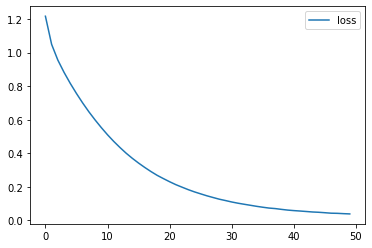

In [11]:
pd.DataFrame(history.history).plot()

### 1) Defining inference models
We create inference models which help in predicting translations.

**Encoder inference model** : Takes the English sentence as input and outputs LSTM states ( `h` and `c` ).

**Decoder inference model** : Takes in 2 inputs, one are the LSTM states ( Output of encoder model ), second are the Vietnamese input sequences ( ones not having the `<start>` tag ). It will output the translations of the English sentence which we fed to the encoder model and its state values.





In [12]:
def make_inference_model():
  encoder_model = models.Model(encoder_inputs, encoder_states)
  
  decoder_state_input_h = layers.Input(shape=(128, ))
  decoder_state_input_c = layers.Input(shape=(128, ))

  decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

  decoder_outputs, state_h, state_c = decoder_lstm(
      decoder_embedding, initial_state=decoder_state_inputs
  )

  decoder_states = [state_h, state_c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = models.Model(
      [decoder_inputs] + decoder_state_inputs,
      [decoder_outputs] + decoder_states)
  
  return encoder_model, decoder_model



```
# This is formatted as code
```

### 2) Making some translations


1.   First, we take a English sequence and predict the state values using `enc_model`.
2.   We set the state values in the decoder's LSTM.
3.   Then, we generate a sequence which contains the `<start>` element.
4.   We input this sequence in the `dec_model`.
5.   We replace the `<start>` element with the element which was predicted by the `dec_model` and update the state values.
6.   We carry out the above steps iteratively till we hit the `<end>` tag or the maximum sequence length.







In [13]:
def str_to_tokens(sentence: str):
  sentence = sentence.lower()
  words = underthesea.word_tokenize(sentence)
  tokens_list = []

  for word in words:
      tokens_list.append(eng_word_dict[word]) 
  return preprocessing.sequence.pad_sequences([tokens_list], maxlen=max_input_length , padding='post')


In [17]:
enc_model, dec_model = make_inference_model()

for epoch in range(encoder_input_data.shape[0]):
  states_values = enc_model.predict(str_to_tokens(input( 'Enter eng sentence : ' )))
  empty_target_seq = np.zeros((1, 1))
  empty_target_seq[0, 0] = vie_word_dict['start']
  stop_condition = False
  decoded_translation = ""

  while not stop_condition:
    dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)
    
    sampled_word_index = np.argmax(dec_outputs[0, -1, :])
  
    sampled_word = None
    
    for word, index in vie_word_dict.items():
      if sampled_word_index == index:
        decoded_translation += f' {word}'
        sampled_word = word

      if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
        stop_condition = True

    empty_target_seq[0 , 0] = sampled_word_index
    states_values = [h , c]

  print(decoded_translation)

Enter eng sentence : Run
 chạy end
Enter eng sentence : Do
 làm gì thì hãy end
Enter eng sentence : Go
 đi end
Enter eng sentence : Run after me
 chạy đi của bạn end
Enter eng sentence : Run for your life
 cho thành phố của tên bạn end
Enter eng sentence : Get out
 ra ngoài đi end
Enter eng sentence : Get out of my car
 chạy xe của tôi đi end


KeyboardInterrupt: ignored

DMô hình giải quyết được output không cố định số từ.

Cũng không tốt lắm, cần dữ liệu nhiều hơn.